In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simplest of Possible GPs
#### Interpolation between error free data points
###### sample from GP prior with a linear or sqexponential kernel 
###### encode similarity along dimension x, similar x values will have similar y values

###### some code taken from  Martin Krasser's
###### https://github.com/krasserm/bayesian-machine-learning


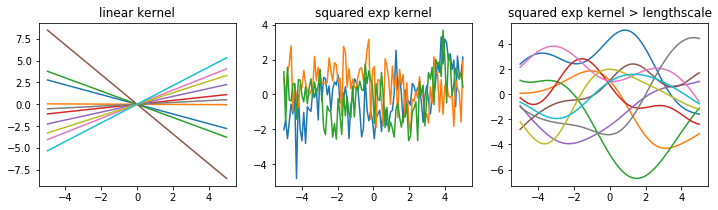

In [52]:
# kernel function gives you the covariance matrix between vectors a and b
n = 100
x = np.linspace(-5,5,n).reshape(-1,1)
y = np.array([1,2,3]).reshape(-1,1)


def kernel(a,b, l=1, sigmaf=1 , sigmay=0,  t_kernel ='sqexp'):
    
    if t_kernel == 'linear':
        return   (a @ b.T)  * 1
    if t_kernel == 'sqexp' and a.shape == b.shape:
        "only works if a and be same sized"
        diff = (a-b.T)**2
        return sigmaf**2 * np.exp((-1/(2*l**2)) * diff)  + sigmay**2 * np.eye(np.size(b))
    else:
        " use two for loops for mxd and nxd matrices.  " 
        " returns mxn covariance matrix " 
        " doesn't allow for error in data "
        K = np.zeros([a.shape[0],b.shape[0]])
        for xi,i in enumerate(a):
            for xj,j in enumerate(b):
                diff = (i-j)**2
                K[xi,xj] = sigmaf**2 * np.exp((-1/(2*l**2)) * diff)
        return K
    
    
    
def GP(x, y, t_kernel='linear', l=1, sigmay=1, sigmaf=1, n_functions=10):
    
    # User defined kernel on user defined dimensions
    # returns nxn covariance matrix
    K = kernel(x,y, t_kernel=t_kernel, sigmay=sigmay, sigmaf=sigmaf,l=l)
    # Use Cholesky decomposition K = LL.T (the square root of a matrix)
    L = np.linalg.cholesky(K + 1e-13*np.eye(n)) # has to be square
    # sample from random normal
    rand = np.random.normal(size=(n,n_functions))
    func = L @ rand
    return func, L, K

f1,L1,K1 = GP(x,x,t_kernel='linear')
f2,L2,K2 = GP(x,x,t_kernel='sqexp', n_functions=3)
f3,L3,K3 = GP(x,x,t_kernel='sqexp',sigmay=1e-4,sigmaf=2,l=2)

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
ax[0].plot(x,f1)
ax[0].set_title('linear kernel')
ax[1].plot(x,f2)
ax[1].set_title('squared exp kernel')
ax[2].plot(x,f3)
ax[2].set_title('squared exp kernel > lengthscale');

Essentially what is happening here is that I am generating a random vector (rand) of size (n,1) from a standard normal distribution N(0,1). I am then matrix multiplying this realization (rand) to the square root of the covariance matrix K. 

$f_{*} \sim \mu + L\mathcal{N}{(0, I)}$

$LL^T = \Sigma_{*}$ 

This imparts some of the information on how similar we think our data should be. Here I am simply using the x axis as the measure of similarity, but this doesn't have to be the case. 

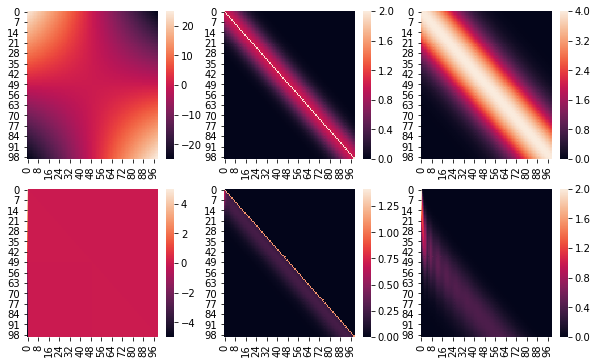

In [19]:
# differnt kernel covariance matrices and their respective square roots L
fig, ax = plt.subplots(2,3, figsize=(10,6))
sns.heatmap(K1, ax=ax[0,0])
sns.heatmap(K2, ax=ax[0,1])
sns.heatmap(K3, ax=ax[0,2])
sns.heatmap(L1, ax=ax[1,0])
sns.heatmap(L2, ax=ax[1,1])
sns.heatmap(L3, ax=ax[1,2]);

###### Now fit GP to some Data

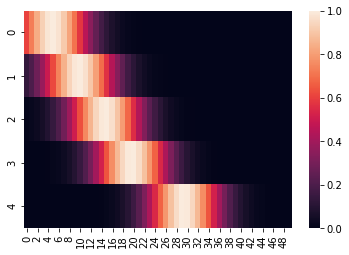

In [25]:
K_s = kernel(Xtrain, Xtest)
sns.heatmap(K_s)

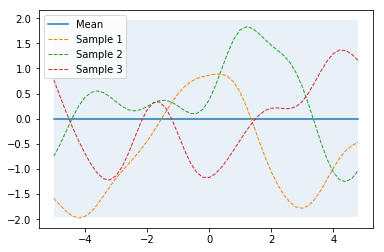

In [205]:
from gaussian_processes_util import plot_gp

import sys, importlib
importlib.reload(sys.modules['gaussian_processes_util'])
from gaussian_processes_util import plot_gp

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

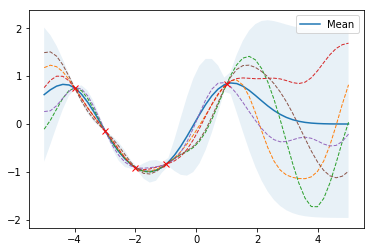

In [206]:
from numpy.linalg import inv

import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f) 
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (15.15) p.520 murphy
    mu_s = K_s.T @ K_inv @ Y_train
    # Equation (15.16)
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

# Noiseless training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
Y_train = np.sin(X_train)
n=50
X_s = np.linspace(-5,5,n).reshape(-1,1)

mu_s, cov_s = posterior_predictive(X_s,Xtrain,ytrain)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)
plot_gp(mu_s, cov_s, X_s, X_train=X_train, Y_train=Y_train, samples=samples, label=False)

In [207]:
mu_s.shape, cov_s.shape


((50, 1), (50, 50))

Basically what we've done here is take a set of *test* points, say 50 along the x axis and asked given the training points and the given covariance/kernel function to test for similarity find a MvN with fifty means one for each *test* point and fifty by fifty covariance structure that keeps similar points similar. The marginal of each of these test points is a one dimensional gaussian and its width its sd. Thats what gives us confidence in the prediction at each x. 

For western wheat I am using lat and long(well distance) as similarity so i will have to change the kernel function. and in the z direction I have w or slope between individual regressions for each farm. 
 

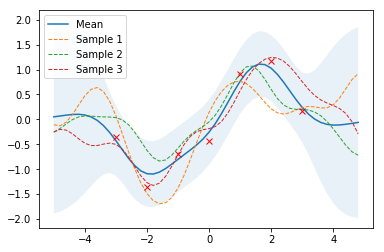

In [208]:
# now with noisey data

noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

Noise enters the model by adding variance aloing the diagnol in our covariance kernel function. We keep the same relation or metric of similarity between x's, now however, we have added uncertainty in the training covariance and by virtue in the posteior covariance matrix as well. 


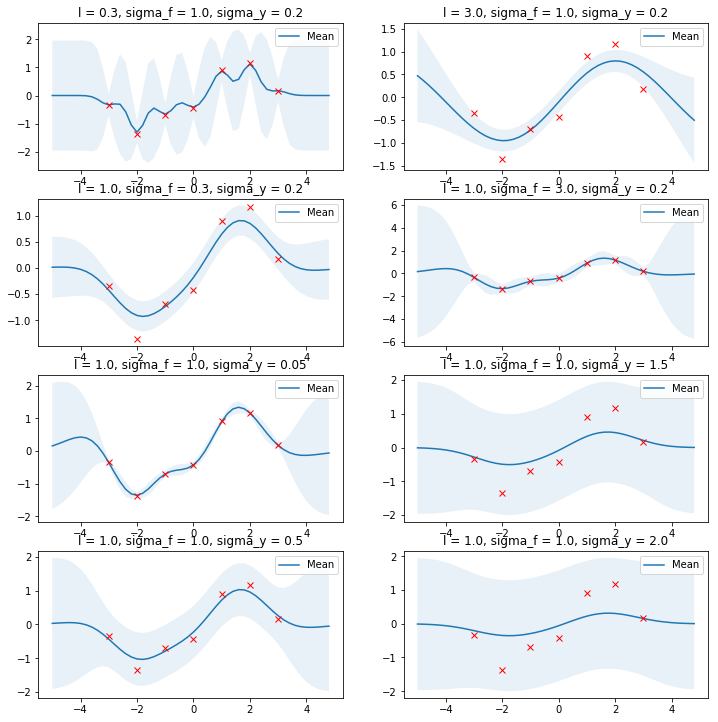

In [209]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
    (1.,1.,.5),
    (1.,1.,2.),

]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(4, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Optimal values for these parameters can be estimated by maximizing the marginal log-likelihood which is given by<sup>[1][3]</sup>

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{7}
$$

In the following we will minimize the negative marginal log-likelihood w.r.t. parameters $l$ and $\sigma_f$, $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, $\sigma_y$ can be estimated as well along with the other parameters. 

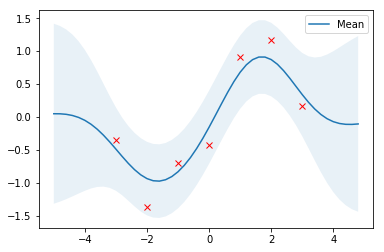

In [210]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

With optimized kernel parameters, training data are reasonably covered by the 95% confidence interval and the mean of the posterior predictive is a good approximation.

### Higher dimensions

The above implementation can also be used for higher input data dimensions. Here, a GP is used to fit noisy samples from a sine wave originating at $\boldsymbol{0}$ and expanding in the x-y plane. The following plots show the noisy samples and the posterior predictive mean before and after kernel parameter optimization.

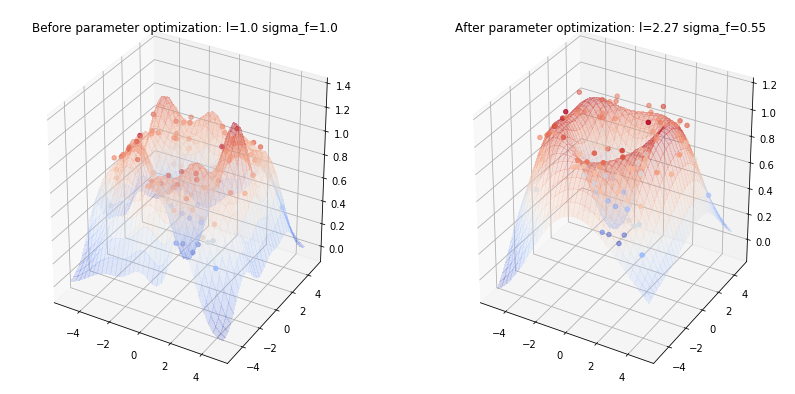

In [211]:
from gaussian_processes_util import plot_gp_2D

noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

##### Use Krasser's 2-D code and posterior predictive function as well as kernel for western wheat

In [ ]:

from gaussian_processes_util import plot_gp_2D

noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

NameError: name 'df_means' is not defined

## *latent* implementation pymc3

By default, PyMC3 reparameterizes the prior on f under the hood by rotating it with the Cholesky factor of its covariance matrix. __This helps to reduce covariances in the posterior of the transformed random variable, v.__  [A common way to sample from MvNs](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution). The reparameterized model is,


\begin{split}\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}\end{split}

###### Using pymc3 for one d GP

###### with kernel function:
$k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]$

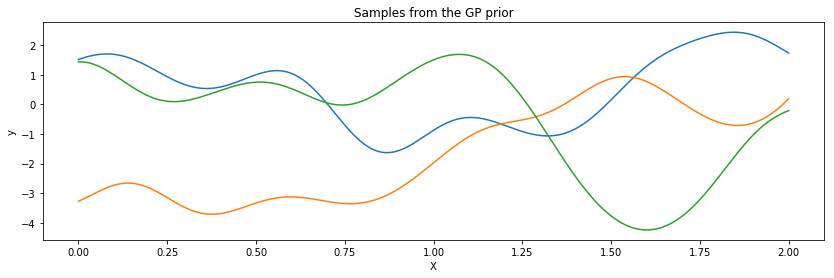

In [143]:
# code from pymc3 docs

lengthscale = 0.2
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");


In [ ]:
import sys

import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

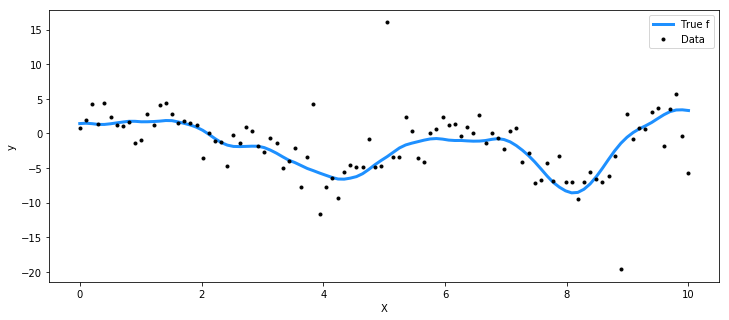

In [184]:
# set the seed
# code from pymc3 docs GP example for latent GP
np.random.seed(1)

n = 10 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

The data above shows the observations, marked with black dots, of the unknown function f(x)

that has been corrupted by noise. The true function is in blue.
Coding the model in PyMC3¶

Here’s the model in PyMC3. We use a Gamma(2,1)
prior over the lengthscale parameter, and weakly informative HalfCauchy(5) priors over the covariance function scale, and noise scale. A Gamma(2,0.1) prior is assigned to the degrees of freedom parameter of the noise. Finally, a GP prior is placed on the unknown function. For more information on choosing priors in Gaussian process models, check out some of recommendations by the Stan folks.

In [192]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=1)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]
100%|██████████| 1500/1500 [01:01<00:00, 24.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


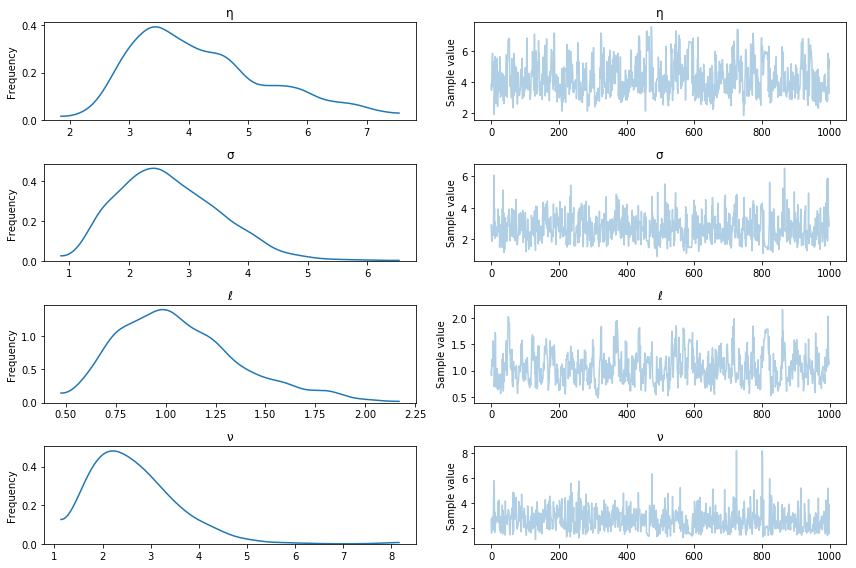

In [190]:
# hyper parameters
pm.traceplot(trace, varnames=["η", "σ", "ℓ", "ν"]);

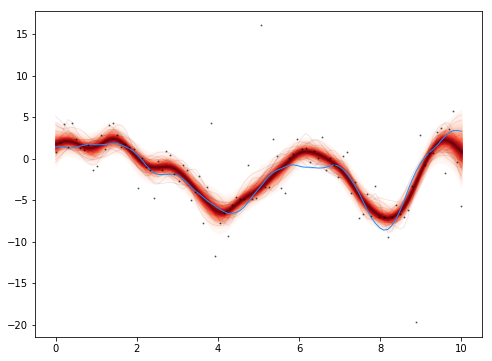

In [197]:
# plot the results
fig = plt.figure(figsize=(8,6)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);
# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=1, label="True f");
plt.plot(X, y, 'ok', ms=1, alpha=0.5, label="Observed data");

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit, and the uncertainty caused by the additive noise. The result also doesn’t over fit due to outliers from the Student-T noise model.
Using .conditional¶

Next, we extend the model by adding the conditional distribution so we can predict at new x
locations. Lets see how the extrapolation looks out to higher x. To do this, we extend our model with the conditional distribution of the GP. Then, we can sample from it using the trace and the sample_posterior_predictive function. This is similar to how Stan uses its generated quantities {...} blocks. We could have included gp.conditional in the model before we did the NUTS sampling, but it is more efficient to separate these steps.

In [198]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:16<00:00, 58.95it/s]


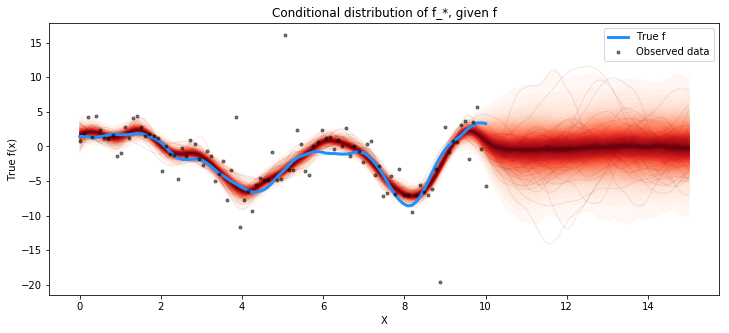

In [199]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

### Marginal Likelihood Implementation¶

The gp.Marginal class implements the more common case of GP regression: the observed data are the sum of a GP and Gaussian noise. gp.Marginal has a marginal_likelihood method, a conditional method, and a predict method. Given a mean and covariance function, the function f(x)

is modeled as,
$$f(x)∼GP(m(x),k(x,x′))$$

The observations y

are the unknown function plus noise
$$ϵy∼N(0,Σ)=f(x)+ϵ$$
The .marginal_likelihood method¶

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood. This quantity is called the marginal likelihood.
$$p(y∣x)=∫p(y∣f,x)p(f∣x)df$$

The log of the marginal likelihood, $p(y∣x)$

, is
$$logp(y∣x)=−12(y−mx)T(Kxx+Σ)−1(y−mx)−12|Kxx+Σ|−n2log(2π)$$

Σ

is the covariance matrix of the Gaussian noise. Since the Gaussian noise doesn’t need to be white to be conjugate, the marginal_likelihood method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The gp.marginal_likelihood method implements the quantity given above. Some sample code would be,

In [202]:

# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None]
y = np.sin(X) + np.random.normal(0,.3,size=X.shape[0]).reshape(-1,1)
with pm.Model() as marginal_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # The scale of the white noise term can be provided,
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)

    # OR a covariance function for the noise can be given
    # noise_l = pm.Gamma("noise_l", alpha=2, beta=2)
    # cov_func_noise = pm.gp.cov.Exponential(1, noise_l) + pm.gp.cov.WhiteNoise(sigma=0.1)
    # y_ = gp.marginal_likelihood("y", X=X, y=y, noise=cov_func_noise)

## Example marginal pymc3

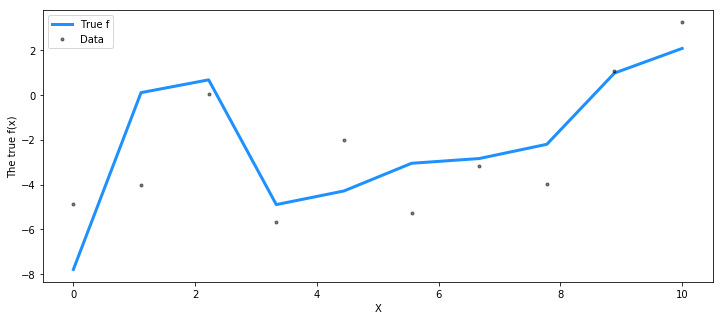

In [221]:
# set the seed
np.random.seed(1)

n = 10 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector


# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();